<a href="https://colab.research.google.com/github/justadudewhohacks/ipynbs/blob/master/single_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
!pip install -U -q PyDrive
!pip install git+https://github.com/justadudewhohacks/image_augment.py
!pip install git+https://github.com/justadudewhohacks/colabsnippets

     |████████████████████████████████| 993kB 29.4MB/s 
  Cloning https://github.com/justadudewhohacks/image_augment.py to /tmp/pip-req-build-hxdg9m7h
  Running command git clone -q https://github.com/justadudewhohacks/image_augment.py /tmp/pip-req-build-hxdg9m7h
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdph0623/wheels/6f/f7/4a/e8e6dc3a68ae11e9b1f6872c5c1be9bed2052f05e487df549f
Successfully built augment
  Cloning https://github.com/justadudewhohacks/colabsnippets to /tmp/pip-req-build-t320rnes
  Running command git clone -q https://github.com/justadudewhohacks/colabsnippets /tmp/pip-req-build-t320rnes
  Stored in directory: /tmp/pip-ephem-wheel-cache-g403fpr2/wheels/a4/f3/4d/514be480c5a7dfea589012f45748e962bfe3563921114afb96
Successfully built colabsnippets


# Download Data

In [2]:
from colabsnippets.DataDownloader import DataDownloader

data_downloader = DataDownloader(data_dir = './data')

data_downloader.download_data({
	"celeba" : [
    { "images": "1oaTkMeYIesUBNUQlsTj51nxdhcj7Z5o2" },
    { "images": "173TZTMajvsP2TF8uSeMXn3jJ6KwjX4tl" },
    { "images": "1jniSHBYdH7wIXAuDU1Kcemd-fIlO7RR8" },
    { "images": "1MQkVJOA1yMBbBzqMt61Xi_G0IUPTq2Zn" },
    { "images": "1wIjYNR_KpFo2kGfTAOggu8NQlSHSSr7-" },
    { "images": "1itHeZ7FtyXDrM1Cbsg9Efe_v04v9jRFL" },
    { "images": "1pmzQAdYgJP-uQP0IvHizcYe9TvovjEcT" },
    { "images": "1jKzx36uLE6lCCidMOGgYmWgaTc5VQphV" },
    { "images": "1n8ccJBEL4C-VzJvCccVtDgsoQQ5Du9e_" },
    { "images": "1D34g2s8huQA91O1hyVk31YljAU_urINF" },
    { "images": "1bO19TM4lmhlAIdLrP7kkjYiH2lGsgff6" },
    { "images": "1hX0jGqqxu2fBdHLEMxZSANnXtNQv7H-D" },
    { "images": "1uj_G2REuXhX6Nd3UyCQo5F653a5JvQTY" },
    { "images": "164-zortF7EZj3ZeywgcrwiJ4OoLXZOzL" },
    { "images": "1QX728oWf9p1idMMSy39xTVVysTBcdoIl" },
    { "images": "1jDOHTb6lIT6IwVPttwF4T6WlnfSik-Dp" },
    { "images": "1YY1nq1aZDlXkdp-9OoODpDyMuYNklEzD" },
    { "images": "190rgRUmfZCnyJzAY0b7ZBehww12zwnja" },
    { "images": "1gdyoJXcCqYfQl8VwEBNObDTxI9-CbWbq" },
    { "images": "1z7lAQpW7hpw651LC0xN6bTlH7vwv7dPS" },
    { "images": "1M02LChNh89bUZgRV4CG3bQzpZxT07WL2" }
	]
}, [])
data_downloader.download_data({
	"imagenet-no-face" : [
    { "images": "1swBeiWC9iXA8_-mLhmVKIQ2xxt7zZKOc" }
	]
}, [])
data_downloader.drive.CreateFile({ 'id': '1rujtZzpWX5DP7E7HaxgqOPpk0cRb0ajD' }).GetContentFile('./data/celeba/landmarks.json')

print('done!')

unzipping images.7z done in 24.655719995498657s
downloading data for shard 11
unzipping images.7z done in 24.885250329971313s
downloading data for shard 12
unzipping images.7z done in 25.14775013923645s
downloading data for shard 13
unzipping images.7z done in 24.97878670692444s
downloading data for shard 14
unzipping images.7z done in 24.94517707824707s
downloading data for shard 15
unzipping images.7z done in 25.328355073928833s
downloading data for shard 16
unzipping images.7z done in 24.91726326942444s
downloading data for shard 17
unzipping images.7z done in 25.145959615707397s
downloading data for shard 18
unzipping images.7z done in 24.930652618408203s
downloading data for shard 19
unzipping images.7z done in 25.44628596305847s
downloading data for shard 20
unzipping images.7z done in 4.106598377227783s
download_data - total time: 580.5500338077545s
downloading data for db: imagenet-no-face
downloading data for shard 0
unzipping images.7z done in 55.087414264678955s
download_dat

# Common

## DataLoader

In [0]:
import cv2
import math
import json
import random
import time
import types
import os
import numpy as np
import tensorflow as tf
from augment import ImageAugmentor, augment
from augment.augment import abs_coords
from colabsnippets.utils import load_json
from colabsnippets import BatchLoader

'''
--------------------------------------------------------------------------------

Data Loader

--------------------------------------------------------------------------------
'''

def min_bbox_from_pts(pts):
  min_x, min_y, max_x, max_y = 1.0, 1.0, 0, 0
  for pt in pts:
    x, y = pt
    min_x = x if x < min_x else min_x
    min_y = y if y < min_y else min_y
    max_x = max_x if x < max_x else x
    max_y = max_y if y < max_y else y

  return [min_x, min_y, max_x, max_y]

landmarks_by_file = load_json('./data/celeba/landmarks.json')
def extract_data_labels(data):
  db = data['db']
  img_file = data['file']
  if db == 'celeba':
    return landmarks_by_file[img_file]
  if db == 'imagenet-no-face':
    return None
  raise Exception("unknown db: {}".format(db))
    
def resolve_image_path(data):
  db = data['db']
  img_file = data['file']
  img_dir = "images-shard{}".format(data['shard']) if 'shard' in data else 'images'
  if db == 'imagenet-no-face':
    img_dir = 'img150'
  img_path = "./data/{}/{}/{}".format(db, img_dir, img_file)
  return img_path

class DataLoader(BatchLoader):
  def __init__(self, data, image_augmentor = None, start_epoch = None, is_test = False, augmentation_prob = 0.0, with_random_sample_min_bbox = False):  
    self.image_augmentor = image_augmentor
    self.augmentation_prob = augmentation_prob
    BatchLoader.__init__(
      self, 
      data if type(data) is types.FunctionType else lambda: data, 
      resolve_image_path, 
      extract_data_labels,
      start_epoch = start_epoch, 
      is_test = is_test
    )
      
  def load_image_and_labels_batch(self, datas, image_size):
    batch_x, batch_y = [], []
    for data in datas:
      landmarks = self.extract_data_labels(data)

      image = self.load_image(data)
      boxes = list(map(lambda pt: pt + [0, 0], landmarks)) if landmarks is not None else []
      if self.image_augmentor is not None and random.random() < self.augmentation_prob:
        min_bbox_landmarks = random.sample(landmarks, 2) if landmarks is not None and with_random_sample_min_bbox else landmarks
        roi = min_bbox_from_pts(min_bbox_landmarks) if landmarks is not None else [0, 0, 1, 1]
        random_crop = { 'roi': roi, 'crop_range': 0, 'apply_before_transform': False }
        image, boxes = self.image_augmentor.augment(image, boxes = boxes, random_crop = roi, pad_to_square = True, resize = image_size)
      else:
        image, boxes = augment(image, boxes = boxes, pad_to_square = True, resize = image_size)
      landmarks = list(map(lambda box: box[0:2], boxes)) if landmarks is not None else None
      
      batch_x.append(image)
      batch_y.append(landmarks)
        
    return batch_x, batch_y
  
        

'''
--------------------------------------------------------------------------------

utility

--------------------------------------------------------------------------------
'''

def gpu_session(callback):
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.allow_soft_placement = True
  config.log_device_placement = True
  with tf.Session(config = config) as session:
    with tf.device('/gpu:0'):
      return callback(session)

def get_checkpoint(model_name, epoch):
  return model_name + '.ckpt-' + str(epoch)

def draw_box(img, box, color = (255, 0, 0)):
  x, y, w, h = abs_coords(box, img)

  cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
  cv2.circle(img, (x, y), 2, (0, 0, 255), -1)
  cv2.circle(img, (x, y + h), 2, (0, 0, 255), -1)
  cv2.circle(img, (x + w, y), 2, (0, 0, 255), -1)
  cv2.circle(img, (x + w, y + h), 2, (0, 0, 255), -1)

def draw_point(img, pt, color = (255, 0, 0)):
  x, y = pt
  y = int(img.shape[1] * y)
  x = int(img.shape[0] * x)
  cv2.circle(img, (x, y), 2, (0, 0, 255), -1)

sigmoid = lambda x: 1 / (1 + math.exp(-x))

## Neural Network

In [0]:
import math
import tensorflow as tf

from colabsnippets import NeuralNetwork
from colabsnippets.ops import conv2d, depthwise_separable_conv2d, fully_connected


class SingleFaceDetector(NeuralNetwork):
  def __init__(self, name = 'single_face_detector', num_blocks = 8):
    super().__init__(self.initialize_weights, name = name)
    self.num_blocks = num_blocks

  def initialize_weights(self, weight_processor):
    def process_reduction_block_weights(channels_in, channels_out, name):
      with tf.variable_scope(name):
        weight_processor.process_depthwise_separable_conv2d_weights(channels_in, channels_out, 'separable_conv0')
        weight_processor.process_depthwise_separable_conv2d_weights(channels_out, channels_out, 'separable_conv1')
        weight_processor.process_conv_weights(channels_in, channels_out, 'expansion_conv', filter_size = 1)

    def process_main_block_weights(channels, name):
      with tf.variable_scope(name):
        weight_processor.process_depthwise_separable_conv2d_weights(channels, channels, 'separable_conv0')
        weight_processor.process_depthwise_separable_conv2d_weights(channels, channels, 'separable_conv1')
        weight_processor.process_depthwise_separable_conv2d_weights(channels, channels, 'separable_conv2')

    with tf.variable_scope(self.name):
      with tf.variable_scope('entry_flow'):
        weight_processor.process_conv_weights(3, 32, 'conv_in', filter_size = 3)
        process_reduction_block_weights(32, 64, 'reduction_block_in')
        process_reduction_block_weights(64, 128, 'reduction_block')

      with tf.variable_scope('middle_flow'):
        for block_num in range(0, self.num_blocks):
          process_main_block_weights(128, 'main_block_' + str(block_num))

      with tf.variable_scope('exit_flow'):
        process_reduction_block_weights(128, 256, 'reduction_block')
        weight_processor.process_depthwise_separable_conv2d_weights(256, 512, 'separable_conv')

      with tf.variable_scope('classifier'):
        weight_processor.process_fc_weights(512, 128, 'fc1')
        weight_processor.process_fc_weights(128, 10, 'fc_landmarks')
        weight_processor.process_fc_weights(128, 1, 'fc_confidence')

  def reduction_block(self, x, name, is_activate_input = True):
    out = x
    with tf.variable_scope(name):
      out = tf.nn.relu(out) if is_activate_input else out
      out = depthwise_separable_conv2d(out, 'separable_conv0', [1, 1, 1, 1])
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv1', [1, 1, 1, 1])
      out = tf.nn.max_pool(out, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
      out = tf.add(out, conv2d(x, 'expansion_conv', [1, 2, 2, 1]))
      return out

  def main_block(self, x, name):
    out = x
    with tf.variable_scope(name):
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv0', [1, 1, 1, 1])
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv1', [1, 1, 1, 1])
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv2', [1, 1, 1, 1])
      out = tf.add(out, x)
      return out

  def forward(self, batch_tensor):
    # TODO: fix dynamic shape
    def normalize(x):
      return tf.divide(tf.subtract(x, 123), 256)
    out = normalize(batch_tensor)

    with tf.variable_scope(self.name, reuse = True):
      with tf.variable_scope('entry_flow'):
        out = tf.nn.relu(conv2d(out, 'conv_in', [1, 2, 2, 1]))
        out = self.reduction_block(out, 'reduction_block_in', is_activate_input = False)
        out = self.reduction_block(out, 'reduction_block')

      with tf.variable_scope('middle_flow'):
        for block_num in range(0, self.num_blocks):
          out = self.main_block(out, 'main_block_' + str(block_num))

      with tf.variable_scope('exit_flow'):
        out = self.reduction_block(out, 'reduction_block')
        out = tf.nn.relu(depthwise_separable_conv2d(out, 'separable_conv', [1, 1, 1, 1]))
        
      with tf.variable_scope('classifier'):
        out = tf.nn.avg_pool(out, [1, 7, 7, 1], [1, 2, 2, 1], 'VALID')
        out = fully_connected(out, 'fc1')
        out_landmarks = tf.reshape(fully_connected(out, 'fc_landmarks'), [-1, 5, 2])
        out_scores = fully_connected(out, 'fc_confidence')

    return out_landmarks, out_scores
  
  
class SingleFaceDetectorLg(NeuralNetwork):
  def __init__(self, name = 'single_face_detector', num_blocks = 8):
    super().__init__(self.initialize_weights, name = name)
    self.num_blocks = num_blocks

  def initialize_weights(self, weight_processor):
    def process_reduction_block_weights(channels_in, channels_out, name):
      with tf.variable_scope(name):
        weight_processor.process_depthwise_separable_conv2d_weights(channels_in, channels_out, 'separable_conv0')
        weight_processor.process_depthwise_separable_conv2d_weights(channels_out, channels_out, 'separable_conv1')
        weight_processor.process_conv_weights(channels_in, channels_out, 'expansion_conv', filter_size = 1)

    def process_main_block_weights(channels, name):
      with tf.variable_scope(name):
        weight_processor.process_depthwise_separable_conv2d_weights(channels, channels, 'separable_conv0')
        weight_processor.process_depthwise_separable_conv2d_weights(channels, channels, 'separable_conv1')
        weight_processor.process_depthwise_separable_conv2d_weights(channels, channels, 'separable_conv2')

    with tf.variable_scope(self.name):
      with tf.variable_scope('entry_flow'):
        weight_processor.process_conv_weights(3, 32, 'conv_in', filter_size = 3)
        process_reduction_block_weights(32, 64, 'reduction_block_in')
        process_reduction_block_weights(64, 128, 'reduction_block')

      with tf.variable_scope('middle_flow'):
        for block_num in range(0, self.num_blocks):
          process_main_block_weights(128, 'main_block_' + str(block_num))

      with tf.variable_scope('exit_flow'):
        process_reduction_block_weights(128, 256, 'reduction_block')
        process_reduction_block_weights(256, 512, 'reduction_block2')
        weight_processor.process_depthwise_separable_conv2d_weights(512, 1024, 'separable_conv')

      with tf.variable_scope('classifier'):
        weight_processor.process_fc_weights(1024, 256, 'fc1')
        weight_processor.process_fc_weights(256, 10, 'fc_landmarks')
        weight_processor.process_fc_weights(256, 1, 'fc_confidence')

  def reduction_block(self, x, name, is_activate_input = True):
    out = x
    with tf.variable_scope(name):
      out = tf.nn.relu(out) if is_activate_input else out
      out = depthwise_separable_conv2d(out, 'separable_conv0', [1, 1, 1, 1])
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv1', [1, 1, 1, 1])
      out = tf.nn.max_pool(out, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
      out = tf.add(out, conv2d(x, 'expansion_conv', [1, 2, 2, 1]))
      return out

  def main_block(self, x, name):
    out = x
    with tf.variable_scope(name):
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv0', [1, 1, 1, 1])
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv1', [1, 1, 1, 1])
      out = depthwise_separable_conv2d(tf.nn.relu(out), 'separable_conv2', [1, 1, 1, 1])
      out = tf.add(out, x)
      return out

  def forward(self, batch_tensor):
    # TODO: fix dynamic shape
    def normalize(x):
      return tf.divide(tf.subtract(x, 123), 256)
    out = normalize(batch_tensor)

    with tf.variable_scope(self.name, reuse = True):
      with tf.variable_scope('entry_flow'):
        out = tf.nn.relu(conv2d(out, 'conv_in', [1, 2, 2, 1]))
        out = self.reduction_block(out, 'reduction_block_in', is_activate_input = False)
        out = self.reduction_block(out, 'reduction_block')

      with tf.variable_scope('middle_flow'):
        for block_num in range(0, self.num_blocks):
          out = self.main_block(out, 'main_block_' + str(block_num))

      with tf.variable_scope('exit_flow'):
        out = self.reduction_block(out, 'reduction_block')
        out = self.reduction_block(out, 'reduction_block2')
        out = tf.nn.relu(depthwise_separable_conv2d(out, 'separable_conv', [1, 1, 1, 1]))
        
      with tf.variable_scope('classifier'):
        out = tf.nn.avg_pool(out, [1, 7, 7, 1], [1, 2, 2, 1], 'VALID')
        out = fully_connected(out, 'fc1')
        out_landmarks = tf.reshape(fully_connected(out, 'fc_landmarks'), [-1, 5, 2])
        out_scores = fully_connected(out, 'fc_confidence')

    return out_landmarks, out_scores

# Train

In [0]:
import math
from colabsnippets.face_detection import calculate_iou
from colabsnippets.face_detection.yolov2 import inverse_sigmoid, create_gt_mask, extract_boxes, extract_coords_and_scores, get_box_grid_position, compile_loss_op

tf.reset_default_graph()

net = SingleFaceDetector(num_blocks = 0)
model_name = net.name + '_blocks0_aug_0_5_rot30_cut'

# training parameters
learning_rate = 0.00005
start_epoch = 30
image_size = 112
batch_size = 128
regression_loss_weight = 100.0
class_loss_weight = 1.0
augmentation_prob = 0.5
with_random_sample_min_bbox = True

train_data = load_json('./celeba_trainData.json')
for i in range(0, 8):
  train_data += load_json('./imagenet-no-face_trainData.json')
image_augmentor = ImageAugmentor.load('./augmentor_4_strong_rot.json')
data_loader = DataLoader(train_data, start_epoch = start_epoch, image_augmentor = image_augmentor, augmentation_prob = augmentation_prob, with_random_sample_min_bbox = with_random_sample_min_bbox)
net.init_trainable_weights()

X = tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3])
GT_LANDMARKS = tf.placeholder(tf.float32, [batch_size, 5, 2])
FACE_MASK = tf.placeholder(tf.float32, [batch_size, 5, 2])
FACE_SCORES = tf.placeholder(tf.float32, [batch_size, 1])
pred_landmarks_op, pred_scores_op = net.forward(X)
#regression_loss_op = tf.losses.mean_squared_error(GT_LANDMARKS, pred_landmarks_op, weights = FACE_MASK)
regression_loss_op = tf.losses.absolute_difference(GT_LANDMARKS, pred_landmarks_op, weights = FACE_MASK)
classification_loss_op = tf.losses.sigmoid_cross_entropy(FACE_SCORES, pred_scores_op)
loss_op = regression_loss_weight * regression_loss_op + class_loss_weight * classification_loss_op
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_op)

saver = tf.train.Saver(max_to_keep = None)
  
print(len(train_data))
log_file = open('./log.txt', 'w')
def train(sess):
  total_loss = 0
  total_classification_loss = 0
  total_regression_loss = 0
  iteration_count = 0
  ts_epoch = time.time()
  
  sess.run(tf.global_variables_initializer())

  if (start_epoch != 0):
    checkpoint = get_checkpoint(model_name, start_epoch - 1)
    saver.restore(sess, checkpoint)
    print('done restoring session')

  while True:
    epoch = data_loader.epoch
    current_idx = data_loader.current_idx
    end_idx = data_loader.get_end_idx()

    ts = time.time()
        
    batch_x, batch_y = data_loader.next_batch(batch_size, image_size)
    batch_gt_landmarks = []
    face_scores = []
    face_mask = []
    for y in batch_y:
      batch_gt_landmarks.append(np.zeros([5, 2]) if y is None else y)
      face_scores.append([0] if y is None else [1])
      face_mask.append(np.zeros([5, 2]) if y is None else np.ones([5, 2]))
    classification_loss, regression_loss, _ = sess.run([classification_loss_op, regression_loss_op, train_op], 
                                                       feed_dict = { X: batch_x, GT_LANDMARKS: batch_gt_landmarks, FACE_SCORES: face_scores, FACE_MASK: face_mask })

    loss = regression_loss_weight * regression_loss + class_loss_weight * classification_loss
    total_loss += loss
    total_classification_loss += classification_loss
    total_regression_loss += regression_loss
    iteration_count += 1     
    
    log_file.write("epoch " + str(epoch) + ", (" + str(current_idx) + " of " + str(end_idx) + "), loss= " + "{:.4f}".format(loss) 
          + ", time= " + str((time.time() - ts) * 1000) + "ms \n")

    if epoch != data_loader.epoch:
      avg_loss = total_loss / iteration_count
      avg_classification_loss = total_classification_loss / iteration_count
      avg_regression_loss = total_regression_loss / iteration_count
      print('next epoch: ' + str(data_loader.epoch))
      print('avg_loss= ' + str(avg_loss))
      print('avg_classification_loss= ' + str(avg_classification_loss))
      print('avg_regression_loss= ' + str(avg_regression_loss))
      saver.save(sess, model_name + '.ckpt', global_step = epoch)

      epoch_txt_file_path = 'epoch_' + str(epoch) + '.txt'
      epoch_txt = open(epoch_txt_file_path, 'w')
      epoch_txt.write('total_loss= ' + str(total_loss) + '\n')
      epoch_txt.write('avg_loss= ' + str(avg_loss) + '\n')
      epoch_txt.write('avg_classification_loss= ' + str(avg_classification_loss) + '\n')
      epoch_txt.write('avg_regression_loss= ' + str(avg_regression_loss) + '\n')
      epoch_txt.write('learning_rate= ' + str(learning_rate) + '\n')
      epoch_txt.write('batch_size= ' + str(batch_size) + '\n')
      epoch_txt.write('epoch_time= ' + str(time.time() - ts_epoch) + 's \n')
      epoch_txt.close()

      total_loss = 0
      total_classification_loss = 0
      total_regression_loss = 0
      iteration_count = 0      
      ts_epoch = time.time()
        
  print('done!')
  log_file.close() 
    
gpu_session(train)

# Scripts

## Extract Image Dims

In [0]:
train_data = load_json('./trainData.json')
test_data = load_json('./testData.json')

files_to_dims = {}
for data in (train_data + test_data):
  img_path = resolve_image_path(data)
  img = cv2.imread(img_path)
  im_h, im_w = img.shape[0:2]
  files_to_dims[img_path] = [im_h, im_w]
  
with open('files_to_dims.json', 'w') as json_file:
  json_file.write(json.dumps(files_to_dims))

## Compute Anchors

In [0]:
files_to_dims = load_json('./files_to_dims.json')

img_size = 416
cell_size = 32
min_box_size = 40
num_anchors = 10

box_dims = []

for key in files_to_dims:
  im_h, im_w = files_to_dims[key]
  boxes_file = key.replace('.jpg', '.json').replace('images', 'boxes')
  boxes = transform_boxes(load_json(boxes_file))
  for box in boxes:
    x, y, w, h = box
    r = img_size / max(im_h, im_w)
    dims = (w * r * im_w), (h * r * im_h)
    if min(dims) < min_box_size:
      continue
      
    dims = (dims[0] / cell_size, dims[1] / cell_size)
    #print (im_h, im_w, r, dims)
    box_dims.append(dims)
  
print (len(box_dims)) 
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS

compactness, labels, centers = cv2.kmeans(np.float32(box_dims), num_anchors, None, criteria, 10, flags)
print(compactness)
print(centers)

## Mean RGB

## Debug

In [0]:
from colabsnippets.face_detection import calculate_iou
from colabsnippets.face_detection.yolov2 import create_gt_mask, create_gt_coords, extract_boxes, extract_coords_and_scores, compile_loss_op

tf.reset_default_graph()

net = TinyYolov2Mobilenet(anchors = default_anchors_416)
model_name = net.name + '_foo'

# training parameters
learning_rate = 0.0005
start_epoch = 0
batch_size = 5
image_size = 416
min_box_size = 40
#image_augmentor = ImageAugmentor.load('./augmentor_4.json')
image_augmentor = None
train_data = filter_data_by_min_box_size(load_json('./trainData.json'), min_box_size)[0:5]
#all_data = load_json('./trainData.json')
#train_data = [all_data[1], all_data[5], all_data[6], all_data[9]]
for data in train_data:
  try:
    boxes = extract_data_labels(data)
  except Exception as e:
    print (data, e)
  

data_loader = DataLoader(train_data, start_epoch = start_epoch, image_augmentor = image_augmentor)
net.init_trainable_weights()

X = tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3])
pred_op = net.forward(X)
anchors = net.anchors
num_cells = pred_op.shape.as_list()[1]
num_anchors = len(anchors)
extract_op = extract_coords_and_scores(pred_op)
GT_MASK = tf.placeholder(tf.float32, [batch_size, num_cells, num_cells, num_anchors, 1])
GT_COORDS = tf.placeholder(tf.float32, [batch_size, num_cells, num_cells, num_anchors, 4])
loss_op = compile_loss_op(pred_op, GT_COORDS, GT_MASK)
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_op[0])

saver = tf.train.Saver(max_to_keep = None)
  
print(len(train_data))
log_file = open('./log.txt', 'w')

def train(sess):
  total_loss = 0
  total_object_loss = 0
  total_coord_loss = 0
  total_no_object_loss = 0
  iteration_count = 0
  ts_epoch = time.time()
  
  sess.run(tf.global_variables_initializer())

  if (start_epoch != 0):
    checkpoint = get_checkpoint(model_name, start_epoch - 1)
    saver.restore(sess, checkpoint)
    print('done restoring session')

  while True:
    epoch = data_loader.epoch
    current_idx = data_loader.current_idx
    end_idx = data_loader.get_end_idx()

    ts = time.time()

    batch_x, batch_gt_boxes = data_loader.next_batch(batch_size, image_size)
    gt_mask = create_gt_mask(batch_gt_boxes, num_cells, anchors)
    gt_coords = create_gt_coords(batch_gt_boxes, num_cells, anchors, is_apply_inverse_sigmoid = True)
    coords_and_scores, losses, _ = sess.run([extract_op, loss_op, train_op], feed_dict = { X: batch_x, GT_MASK: gt_mask, GT_COORDS: gt_coords })
    loss, object_loss, coord_loss, no_object_loss = losses
    
    coords, scores = coords_and_scores
    batch_boxes = extract_boxes(coords, scores, anchors, min_score = 0.5, is_apply_sigmoid = True)
    
    is_done = False
    num_matches = 0
    for batch_idx, boxes in enumerate(batch_gt_boxes):
      for box_idx, box in enumerate(boxes):
        if box_idx >= len(batch_boxes[batch_idx]):
          break
        batch_boxes[batch_idx][box_idx]

        iou = calculate_iou(box, batch_boxes[batch_idx][box_idx])

        if iou > 0.1:
          num_matches += 1
    is_done = num_matches > 2
    if (is_done):
      print(np.where(scores > 0.5))
    # TODO
    
    total_loss += loss
    total_object_loss += object_loss
    total_coord_loss += coord_loss
    total_no_object_loss += no_object_loss
    for gt_boxes in batch_gt_boxes:
      iteration_count += len(gt_boxes)
    
    log_file.write("epoch " + str(epoch) + ", (" + str(current_idx) + " of " + str(end_idx) + "), loss= " + "{:.4f}".format(loss) 
          + ", time= " + str((time.time() - ts) * 1000) + "ms \n")

    if epoch != data_loader.epoch:
      avg_loss = total_loss / iteration_count
      avg_object_loss = total_object_loss / iteration_count
      avg_coord_loss = total_coord_loss / iteration_count
      avg_no_object_loss = total_no_object_loss / iteration_count
      if is_done:
        print('next epoch: ' + str(data_loader.epoch))
        print('avg_loss= ' + str(avg_loss))
        print('avg_object_loss= ' + str(avg_object_loss))
        print('avg_coord_loss= ' + str(avg_coord_loss))
        print('avg_no_object_loss= ' + str(avg_no_object_loss))
        saver.save(sess, model_name + '.ckpt', global_step = epoch)

        epoch_txt_file_path = 'epoch_' + str(epoch) + '.txt'
        epoch_txt = open(epoch_txt_file_path, 'w')
        epoch_txt.write('total_loss= ' + str(total_loss) + '\n')
        epoch_txt.write('avg_loss= ' + str(avg_loss) + '\n')
        epoch_txt.write('learning_rate= ' + str(learning_rate) + '\n')
        epoch_txt.write('batch_size= ' + str(batch_size) + '\n')
        epoch_txt.write('epoch_time= ' + str(time.time() - ts_epoch) + 's \n')
        epoch_txt.close()
        raise "done"

      total_loss = 0
      total_object_loss = 0
      total_coord_loss = 0
      total_no_object_loss = 0
      iteration_count = 0      
      ts_epoch = time.time()
        
  print('done!')
  log_file.close() 
    
gpu_session(train)

# Test

## Forward

In [12]:
from colabsnippets.face_detection.yolov2 import create_gt_mask, create_gt_coords, extract_boxes, extract_coords_and_scores, sigmoid
from colabsnippets.utils import save_weights

tf.reset_default_graph()

is_lg_input = False
net = SingleFaceDetector(num_blocks = 0)
model_name = net.name + '_blocks0_aug_0_5_rot30_cut'
net.init_trainable_weights()

db = None
epoch = 31
image_size = 224 if is_lg_input else 112
batch_size = 1

image_augmentor = None
#image_augmentor = ImageAugmentor.load('./augmentor_4.json')
train_data = load_json('./celeba_testData.json') + load_json('./imagenet-no-face_testData.json')
#train_data = load_json('./imagenet-no-face_testData.json')
#train_data = load_json('./celeba_testData.json')
data_loader = DataLoader(train_data, start_epoch = epoch, image_augmentor = image_augmentor, is_test = True, augmentation_prob = 1.0)

X = tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3])
pred_landmarks_op, pred_scores_op = net.forward(X)
pred_scores_logit_op = tf.nn.sigmoid(pred_scores_op)

saver = tf.train.Saver(max_to_keep = None)

def run(sess):
  checkpoint = get_checkpoint(model_name, epoch)
  saver.restore(sess, checkpoint)
  print('done restoring session')

  #print([e.name for e in tf.global_variables()])
  #save_weights(tf.global_variables(), 'single_face_detector_rot30_epoch30')
  #arr = np.load('single_face_detector_rot30_epoch30.npy', allow_pickle = True)
  #arr.tofile('single_face_detector_rot30_epoch30.weights')
  
  get_next_batch = lambda : data_loader.next_batch(batch_size, image_size)
  next_batch = get_next_batch()
  
  results = []
  while (next_batch != None):
    batch_x, batch_gt_landmarks = next_batch
    batch_pred_landmarks, batch_pred_scores = sess.run([pred_landmarks_op, pred_scores_logit_op], feed_dict = { X: batch_x })

    for batch_idx, gt_landmarks in enumerate(batch_gt_landmarks):
      results.append((gt_landmarks, batch_pred_landmarks[batch_idx], batch_pred_scores[batch_idx]))
      
    next_batch = get_next_batch()
  
  np.save("{}_epoch{}_image_size{}_test".format(model_name, epoch, image_size), results, allow_pickle = True)

gpu_session(run)

done restoring session


## Test

In [13]:
from colabsnippets.face_detection import calculate_iou
from colabsnippets.utils import load_json

model_name = SingleFaceDetector(num_blocks = 0).name + '_blocks0_aug_0_5_rot30_cut'
epoch = 31
is_lg_input = False
image_size = 224 if is_lg_input else 112

filename = "{}_epoch{}_image_size{}_test.npy".format(model_name, epoch, image_size)
results = np.load(filename, allow_pickle = True)

total_sae = 0
total_sse = 0
total_iou = 0
total_score_0_3 = 0
total_score_0_5 = 0
total_score_0_8 = 0
total_err_score_0_3 = 0
total_err_score_0_5 = 0
total_err_score_0_8 = 0
total_fp_score_0_3 = 0
total_fp_score_0_5 = 0
total_fp_score_0_8 = 0
num_faces = 0
num_no_faces = 0
for res in results:
  gt_landmarks, pred_landmarks, pred_score = res
  if pred_score > 0.3:
    total_score_0_3 += 1
  if pred_score > 0.5:
    total_score_0_5 += 1
  if pred_score > 0.8:
    total_score_0_8 += 1
  if gt_landmarks is None and pred_score > 0.3:
    total_fp_score_0_3 += 1
  if gt_landmarks is None and pred_score > 0.5:
    total_fp_score_0_5 += 1
  if gt_landmarks is None and pred_score > 0.8:
    total_fp_score_0_8 += 1
  if gt_landmarks is not None and pred_score < 0.3:
    total_err_score_0_3 += 1
  if gt_landmarks is not None and pred_score < 0.5:
    total_err_score_0_5 += 1
  if gt_landmarks is not None and pred_score < 0.8:
    total_err_score_0_8 += 1
  
  if gt_landmarks is None:
    num_no_faces += 1
    continue
  pred_landmarks = np.array(pred_landmarks) * 112
  gt_landmarks = np.array(gt_landmarks) * 112
  sae = np.sum(np.abs(pred_landmarks - gt_landmarks)) / 5
  sse = np.sum(np.square(pred_landmarks - gt_landmarks)) / 5
  iou = calculate_iou(min_bbox_from_pts(pred_landmarks), min_bbox_from_pts(gt_landmarks))
  total_sae += sae
  total_sse += sse
  total_iou += iou
  num_faces += 1
  
print(len(results))
print(filename)
print("sae {:.2f}".format(total_sae / num_faces))
print("sse {:.2f}".format(total_sse / num_faces))
print("iou {:.2f}".format(total_iou / num_faces))
print("err_score_0_5 {:.2f}".format(total_err_score_0_5 / num_faces))
print("fp_score_0_5 {:.2f}".format(total_fp_score_0_5 / num_no_faces))
print("num_faces {}".format(num_faces))
print("num_no_faces {}".format(num_no_faces))
print("total_score_0_3 {}".format(total_score_0_3))
print("total_score_0_5 {}".format(total_score_0_5))
print("total_score_0_8 {}".format(total_score_0_8))
print("total_err_score_0_3 {}".format(total_err_score_0_3))
print("total_err_score_0_5 {}".format(total_err_score_0_5))
print("total_err_score_0_8 {}".format(total_err_score_0_8))
print("total_fp_score_0_3 {}".format(total_fp_score_0_3))
print("total_fp_score_0_5 {}".format(total_fp_score_0_5))
print("total_fp_score_0_8 {}".format(total_fp_score_0_8))


23489
single_face_detector_blocks0_aug_0_5_rot30_cut_epoch31_image_size112_test.npy
sae 1.28
sse 3.38
iou 0.98
err_score_0_5 0.00
fp_score_0_5 0.05
num_faces 19962
num_no_faces 3527
total_score_0_3 20146
total_score_0_5 20071
total_score_0_8 19946
total_err_score_0_3 46
total_err_score_0_5 71
total_err_score_0_8 136
total_fp_score_0_3 230
total_fp_score_0_5 180
total_fp_score_0_8 120


In [0]:
lg blocks0 aug_0_5 epoch4 image_size224
sae 8.33
sse 59.66
iou 0.85
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_epoch10_image_size112_test.npy
sae 2.35
sse 7.11
iou 0.96
err_score_0_5 0.00
fp_score_0_5 0.06

single_face_detector_blocks0_aug_0_5_epoch14_image_size112_test.npy
sae 2.23
sse 6.46
iou 0.96

absdiff loss:

single_face_detector_blocks0_aug_0_5_epoch3_image_size112_test.npy
sae 2.13
sse 7.24
iou 0.96
err_score_0_5 0.02
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_epoch5_image_size112_test.npy
sae 1.91
sse 6.59
iou 0.96
err_score_0_5 0.01
fp_score_0_5 0.05

single_face_detector_blocks0_aug_0_5_epoch11_image_size112_test.npy
sae 1.63
sse 4.97
iou 0.97
err_score_0_5 0.01
fp_score_0_5 0.05

single_face_detector_blocks0_aug_0_5_epoch12_image_size112_test.npy
sae 1.34
sse 3.75
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_epoch16_image_size112_test.npy
sae 1.27
sse 3.44
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_epoch17_image_size112_test.npy
sae 1.28
sse 3.34
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_epoch19_image_size112_test.npy
sae 1.26
sse 3.34
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_epoch21_image_size112_test.npy
sae 1.28
sse 3.51
iou 0.98

single_face_detector_blocks0_aug_0_5_epoch23_image_size112_test.npy
sae 1.24
sse 3.26
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_rot30_epoch13_image_size112_test.npy
sae 1.70
sse 5.84
iou 0.97
err_score_0_5 0.01
fp_score_0_5 0.02

single_face_detector_blocks0_aug_0_5_rot30_epoch14_image_size112_test.npy
sae 1.29
sse 3.45
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_rot30_epoch15_image_size112_test.npy
sae 1.30
sse 3.57
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_rot30_epoch18_image_size112_test.npy
sae 1.25
sse 3.24
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_rot30_epoch24_image_size112_test.npy
sae 1.27
sse 3.58
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch20_image_size112_test.npy
sae 1.35
sse 3.83
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch21_image_size112_test.npy
sae 1.31
sse 3.42
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.03

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch22_image_size112_test.npy
sae 1.33
sse 3.42
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch23_image_size112_test.npy
sae 1.31
sse 3.48
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch24_image_size112_test.npy
sae 1.31
sse 3.40
iou 0.98
err_score_0_5 0.00
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch26_image_size112_test.npy
sae 1.28
sse 3.23
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch25_image_size112_test.npy
sae 1.31
sse 3.48
iou 0.98
err_score_0_5 0.01
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch29_image_size112_test.npy
sae 1.28
sse 3.34
iou 0.98
err_score_0_5 0.00
fp_score_0_5 0.04

single_face_detector_blocks0_aug_0_5_rot30_cut_epoch30_image_size112_test.npy
sae 1.26
sse 3.18
iou 0.98
err_score_0_5 0.00
fp_score_0_5 0.04

In [0]:

blocks0 epoch5 aug_0_0:
sae 5.94
sse 35.06
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.06

blocks0 epoch6 aug_0_0:
sae 5.79
sse 33.89
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.09

blocks0 epoch7 aug_0_0:
sae 5.67
sse 32.51
iou 0.90
err_score_0_5 0.00
fp_score_0_5 0.09

blocks0 epoch8 aug_0_0:
sae 5.62
sse 32.19
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.09

blocks0 epoch9 aug_0_0:
sae 5.63
sse 32.23
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.08

blocks0 epoch10 aug_0_0:
sae 5.58
sse 31.80
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.08

blocks0 epoch15 aug_0_0:
sae 5.35
sse 29.88
iou 0.91
err_score_0_5 0.01
fp_score_0_5 0.08


blocks0 epoch9 aug_0_5:
sae 5.98
sse 34.78
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.05

blocks0 epoch10 aug_0_5:
sae 5.86
sse 33.31
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.06

blocks0 epoch13 aug_0_5:
sae 5.75
sse 32.36
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.06

blocks0 epoch17 aug_0_5:
sae 5.96
sse 34.37
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.07

blocks0 epoch18 aug_0_5:
sae 5.79
sse 32.49
iou 0.90
err_score_0_5 0.01
fp_score_0_5 0.07

blocks0 epoch25 aug_0_5:
sae 5.66
sse 31.40
iou 0.91
err_score_0_5 0.01
fp_score_0_5 0.07



blocks8 epoch5 aug_0_5:
sae 5.42
sse 29.07
iou 0.91
err_score_0_5 0.01
fp_score_0_5 0.06

blocks8 epoch7 aug_0_5:
sae 5.14
sse 26.39
iou 0.91
err_score_0_5 0.01
fp_score_0_5 0.06

blocks8 epoch9 aug_0_5:
sae 5.22
sse 26.17
iou 0.91
err_score_0_5 0.00
fp_score_0_5 0.07

blocks8 epoch11 aug_0_5:
sae 4.71
sse 22.81
iou 0.92
err_score_0_5 0.00
fp_score_0_5 0.08

blocks8 epoch12 aug_0_5:
sae 4.89
sse 23.80
iou 0.92
err_score_0_5 0.00
fp_score_0_5 0.07


blocks8 epoch21 aug_0_5:
sae 4.41
sse 20.44
iou 0.92
err_score_0_5 0.00
fp_score_0_5 0.08

blocks16 epoch7 aug_0_5:
sae 5.57
sse 29.52
iou 0.91
err_score_0_5 0.01
fp_score_0_5 0.06

blocks16 epoch10 aug_0_5:
sae 5.18
sse 26.37
iou 0.91
err_score_0_5 0.00
fp_score_0_5 0.08


blocks16 epoch18 aug_0_5:
sae 4.71
sse 22.54
iou 0.92
err_score_0_5 0.00
fp_score_0_5 0.08



-----------

blocks8 epoch6:
sae 9.03
sse 77.32
iou 0.89
err_score_0_5 0.02
fp_score_0_5 0.05

blocks0 epoch8:
sae 9.40
sse 82.12
iou 0.87
err_score_0_5 0.02
fp_score_0_5 0.12

blocks0 epoch9:
sae 9.77
sse 88.33
iou 0.87
err_score_0_5 0.01
fp_score_0_5 0.12

blocks0 epoch10 aug_1_0:
sae 9.62
sse 87.02
iou 0.87
err_score_0_5 0.01
fp_score_0_5 0.09


## Results

### sm_blocks0_epoch3
- sae 6.579817555636804
- sse 54.354032001740336
- iou 0.9239942639893354

### sm_blocks0_epoch11

- sae 6.286744254826902
- sse 51.6531945415472
- iou 0.9282922727833259

### sm_blocks4_epoch8

- sae 6.535094402019345
- sse 54.912014974521675
- iou 0.9275000096533855

### blocks0_epoch7_image_size112

- sae 6.375474851540636
- sse 51.14444951127978
- iou 0.9265296013005409

### blocks0_epoch7_image_size224_test.npy
- sae 6.030191489088201
- sse 47.56423208612117
- iou 0.9288160164071487


###  lg_blocks0_epoch5_image_size224_test.npy
- sae 6.545463780093891
- sse 53.65741916361356
- iou 0.9187845688156441

## Plot Boxes

done restoring session


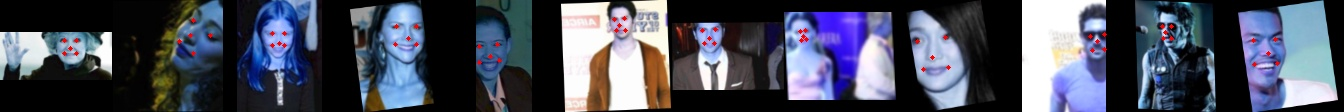

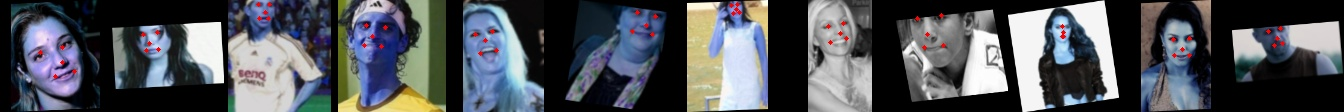

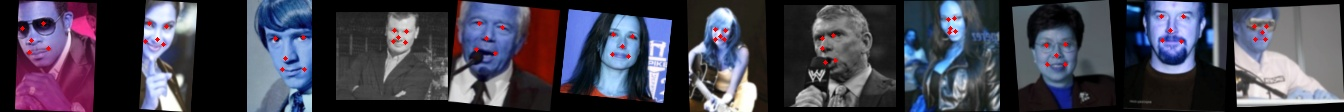

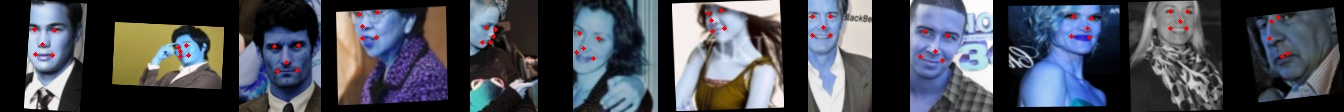

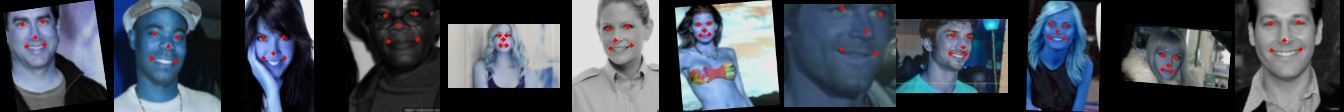

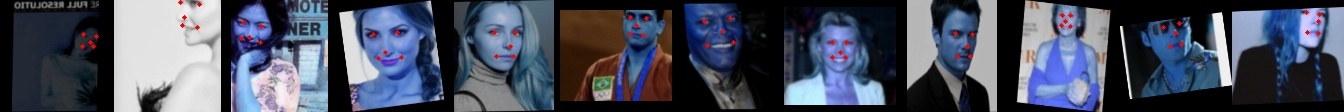

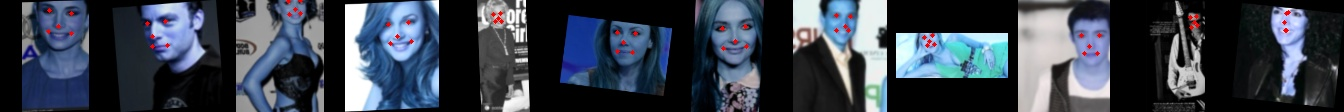

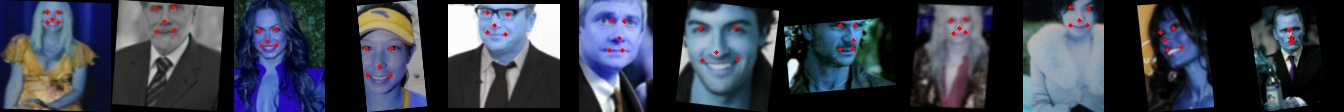

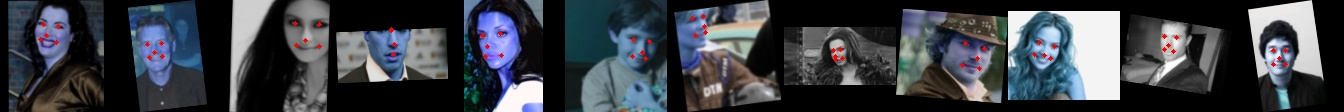

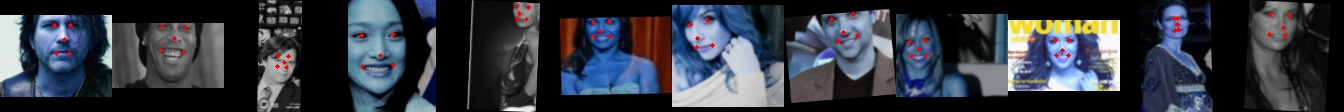

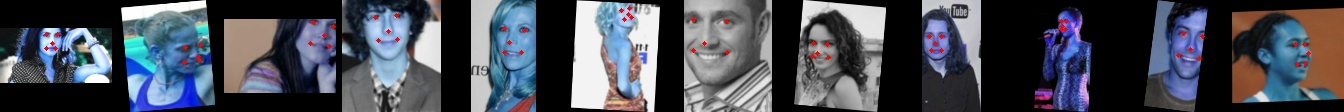

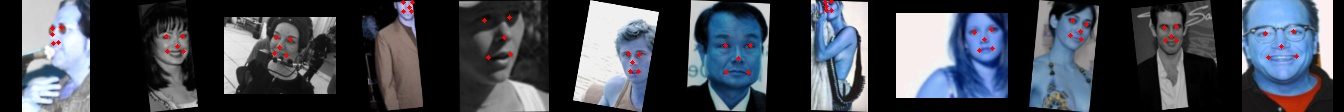

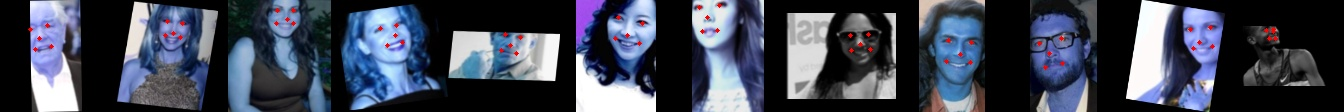

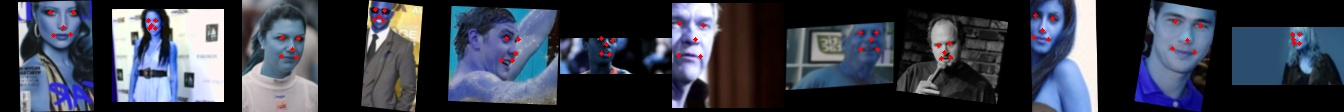

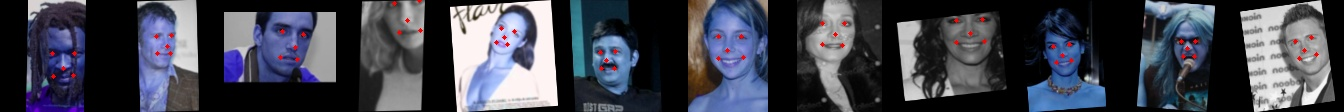

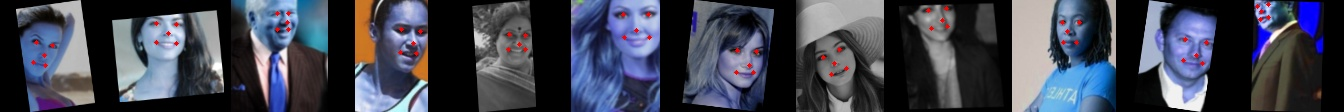

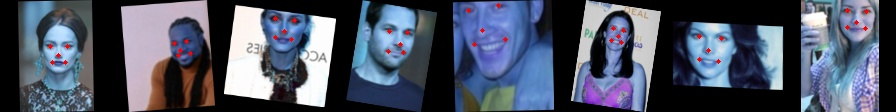

In [0]:
!rm -rf ./check_inputs && mkdir ./check_inputs

from IPython.display import Image, display
from colabsnippets.face_detection.yolov2 import create_gt_mask, create_gt_coords, extract_boxes, extract_coords_and_scores, sigmoid

tf.reset_default_graph()

net = SingleFaceDetector(num_blocks = 0)
model_name = net.name + '_blocks0_aug_0_5'
net.init_trainable_weights()

db = None
epoch = 17
from_data_idx = 0
num_inputs = 200
image_size = 112
num_images_per_row = 12

#image_augmentor = None
image_augmentor = ImageAugmentor.load('./augmentor_4.json')
train_data = load_json('./celeba_testData.json')[from_data_idx:]
data_loader = DataLoader(train_data, start_epoch = epoch, image_augmentor = image_augmentor, is_test = True, augmentation_prob = 1.0)

X = tf.placeholder(tf.float32, [num_inputs, image_size, image_size, 3])
pred_op, scores_op = net.forward(X)

saver = tf.train.Saver(max_to_keep = None)


def run(sess):
  #sess.run(tf.global_variables_initializer())

  if (epoch != 0):
    checkpoint = get_checkpoint(model_name, epoch)
    saver.restore(sess, checkpoint)
    print('done restoring session')

  db_data = []
  for data in train_data:
    if db is None or data['db'] == db:
      db_data.append(data)

  batch_x, batch_gt_landmarks = data_loader.next_batch(num_inputs, image_size)
  batch_landmarks, = sess.run([pred_op], feed_dict = { X: batch_x })

  file_idx = 0
  idx = 0
  while idx < num_inputs:
    imgs = np.stack(batch_x[idx : idx + num_images_per_row], axis = 0)
    preds = batch_landmarks[idx : idx + num_images_per_row]
    
    for i, landmarks in enumerate(preds):
      #print(coords[batch_idx, col, row, anchor_idx])
      for pt in landmarks:
        draw_point(imgs[i], pt, color = (0, 255, 0))

    merged_img = np.concatenate(imgs, axis = 1)

    file = './check_inputs/' + str(file_idx) + '.jpg'
    cv2.imwrite(file, merged_img)
    display(Image(file))

    file_idx += 1
    idx += num_images_per_row

gpu_session(run)
    
!rm -rf ./check_inputs

## Plot Boxes and Predict

In [0]:
!rm -rf ./check_inputs && mkdir ./check_inputs

from IPython.display import Image, display
from colabsnippets.face_detection.yolov2 import create_gt_mask, create_gt_coords, extract_boxes, extract_coords_and_scores, sigmoid

from_data_idx = 20
num_inputs = 20
image_size = 128
min_box_size = 50
num_images_per_row = 2
min_score = 0.1
db = 'WIDER'
is_apply_sigmoid = True

#image_augmentor = None
image_augmentor = ImageAugmentor.load('./augmentor_4.json')
#all_data = load_json('./trainData.json')
#train_data = [all_data[1], all_data[5], all_data[6], all_data[9]]
train_data = load_json('./trainData.json')[from_data_idx:]
data_loader = DataLoader(train_data, start_epoch = epoch, image_augmentor = image_augmentor, is_test = True)


X = tf.placeholder(tf.float32, [num_inputs, image_size, image_size, 3])
pred_op = net.forward(X)
num_cells = pred_op.shape.as_list()[1]


def run(sess):
  #sess.run(tf.global_variables_initializer())

  db_data = []
  for data in train_data:
    if db is None or data['db'] == db:
      db_data.append(data)

  batch_x, batch_gt_boxes = data_loader.next_batch(num_inputs, image_size, min_box_size)
  gt_mask = create_gt_mask(batch_gt_boxes, num_cells, net.anchors)
  gt_coords = create_gt_coords(batch_gt_boxes, num_cells, net.anchors, is_apply_inverse_sigmoid = is_apply_sigmoid)
  expected = np.where(gt_mask > min_score)
  
  expected_matches = extract_matches(expected)
  print(expected_matches)

  file_idx = 0
  idx = 0
  while idx < num_inputs:
    imgs = np.stack(batch_x[idx : idx + num_images_per_row], axis = 0)
    gt_boxes = batch_gt_boxes[idx : idx + num_images_per_row]
    print('ground_truth')
    for i, boxes in enumerate(gt_boxes):
      for j, box in enumerate(boxes):
        draw_box(imgs[i], box)

    merged_img = np.concatenate(imgs, axis = 1)

    file = './check_inputs/' + str(file_idx) + '.jpg'
    cv2.imwrite(file, merged_img)
    display(Image(file))

    file_idx += 1
    idx += num_images_per_row

gpu_session(run)
    
!rm -rf ./check_inputs

# Debug

## Check Inputs

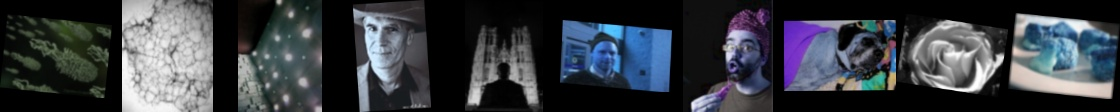

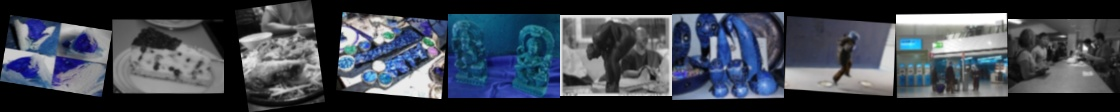

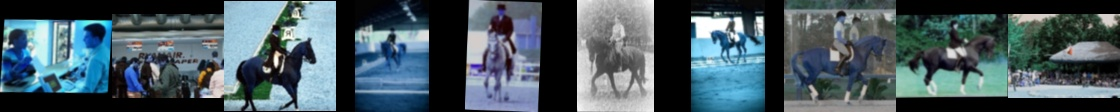

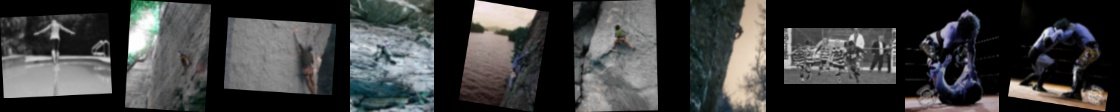

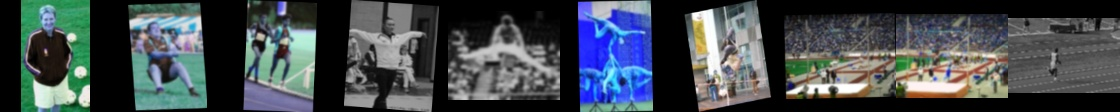

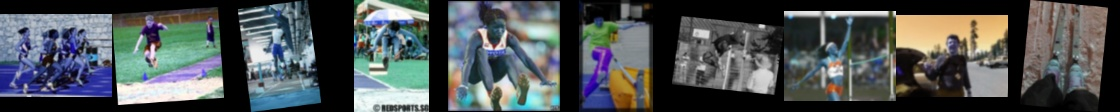

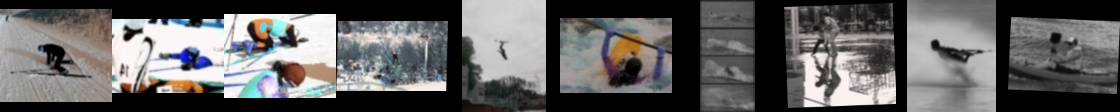

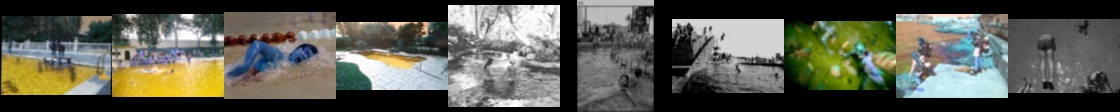

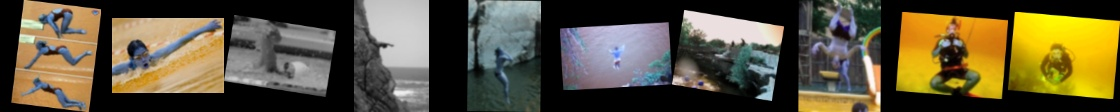

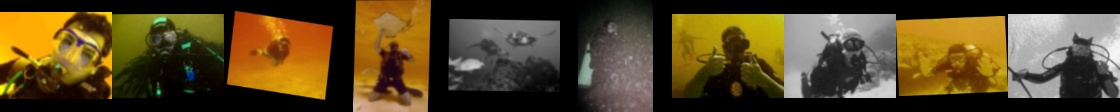

In [0]:
!rm -rf ./check_inputs && mkdir ./check_inputs

from IPython.display import Image, display

num_inputs = 100
image_size = 112
num_images_per_row = 10
db = None

#image_augmentor = None
image_augmentor = ImageAugmentor.load('./augmentor_4.json')
train_data = load_json('./imagenet-no-face_trainData.json')
#train_data = load_json('./imagenet-no-face_trainData.json')[100:]
#train_data = load_json('./celeba_trainData.json')

db_data = []
for data in train_data:
  if db is None or data['db'] == db:
    db_data.append(data)
    
data_loader = DataLoader(db_data, start_epoch = 0, image_augmentor = image_augmentor, is_test = True)
batch_x, batch_y = data_loader.next_batch(num_inputs, image_size)

file_idx = 0
idx = 0
while idx < num_inputs:
  imgs = np.stack(batch_x[idx : idx + num_images_per_row], axis = 0)
  all_landmarks = batch_y[idx : idx + num_images_per_row]
  for i, landmarks in enumerate(all_landmarks):
    if landmarks is None:
      continue
    for pt in landmarks:
      draw_point(imgs[i], pt)
  
  merged_img = np.concatenate(imgs, axis = 1)
  
  file = './check_inputs/' + str(file_idx) + '.jpg'
  cv2.imwrite(file, merged_img)
  display(Image(file))
  
  file_idx += 1
  idx += num_images_per_row

!rm -rf ./check_inputs

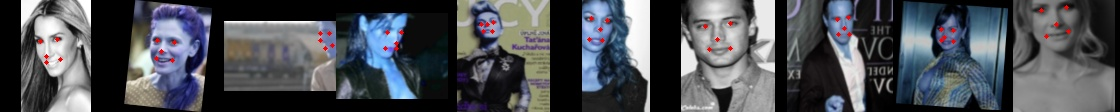

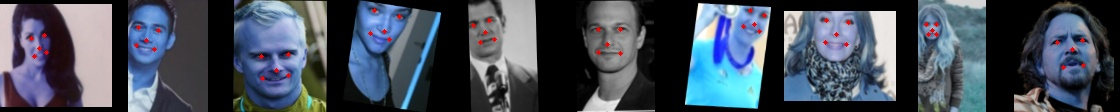

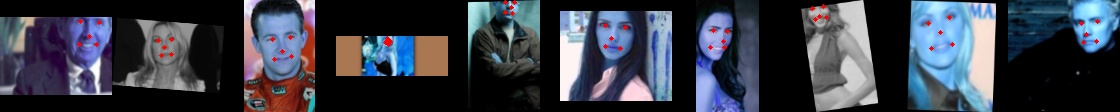

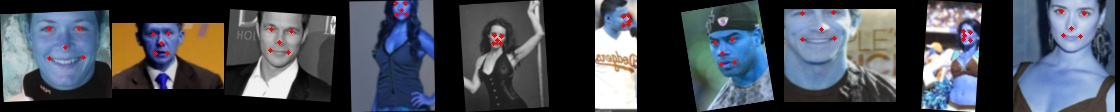

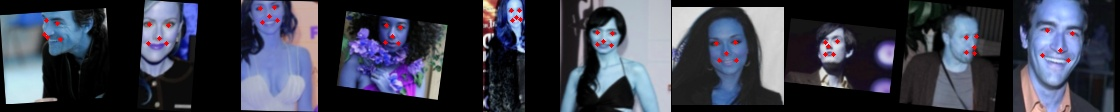

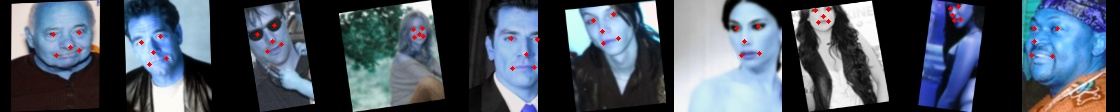

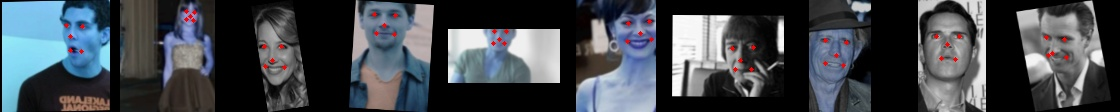

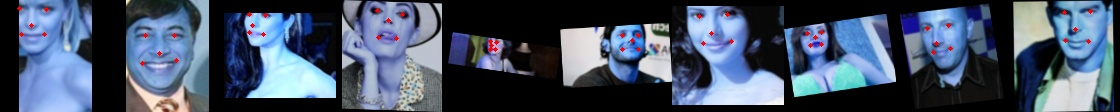

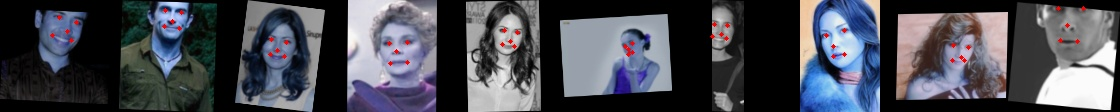

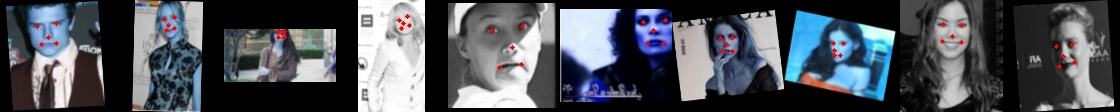

In [0]:
!rm -rf ./check_inputs && mkdir ./check_inputs

from IPython.display import Image, display

num_inputs = 100
image_size = 112
num_images_per_row = 10
db = None

#image_augmentor = None
image_augmentor = ImageAugmentor.load('./augmentor_4.json')
#train_data = load_json('./imagenet-no-face_trainData.json')
#train_data = load_json('./imagenet-no-face_trainData.json')[100:]
train_data = load_json('./celeba_trainData.json')

db_data = []
for data in train_data:
  if db is None or data['db'] == db:
    db_data.append(data)
    
data_loader = DataLoader(db_data, start_epoch = 0, image_augmentor = image_augmentor, is_test = True)
batch_x, batch_y = data_loader.next_batch(num_inputs, image_size)

file_idx = 0
idx = 0
while idx < num_inputs:
  imgs = np.stack(batch_x[idx : idx + num_images_per_row], axis = 0)
  all_landmarks = batch_y[idx : idx + num_images_per_row]
  for i, landmarks in enumerate(all_landmarks):
    if landmarks is None:
      continue
    for pt in landmarks:
      draw_point(imgs[i], pt)
  
  merged_img = np.concatenate(imgs, axis = 1)
  
  file = './check_inputs/' + str(file_idx) + '.jpg'
  cv2.imwrite(file, merged_img)
  display(Image(file))
  
  file_idx += 1
  idx += num_images_per_row

!rm -rf ./check_inputs

## Overfit

In [0]:
import math
from colabsnippets.face_detection import calculate_iou
from colabsnippets.face_detection.yolov2 import inverse_sigmoid, create_gt_mask, extract_boxes, extract_coords_and_scores, get_box_grid_position, compile_loss_op

tf.reset_default_graph()

net = SingleFaceDetector(num_blocks = 0)
model_name = net.name + '_blocks0'

# training parameters
learning_rate = 0.001
start_epoch = 0
image_size = 112
batch_size = 16
image_augmentor = ImageAugmentor.load('./augmentor_4.json')

train_data = load_json('./celeba_trainData.json')[0:64]
train_data += load_json('./imagenet-no-face_trainData.json')[0:64]

data_loader = DataLoader(train_data, start_epoch = start_epoch, image_augmentor = image_augmentor)
net.init_trainable_weights()

X = tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3])
FACE_SCORES = tf.placeholder(tf.float32, [batch_size, 1])
pred_landmarks_op, pred_scores_logits_op = net.forward(X)
#classification_loss_op = tf.reduce_mean(tf.abs(FACE_SCORES - tf.nn.sigmoid(pred_scores_logits_op)))
pred_scores_op = tf.nn.sigmoid(pred_scores_logits_op)
classification_loss_op = tf.losses.sigmoid_cross_entropy(FACE_SCORES, pred_scores_logits_op)
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(classification_loss_op)

saver = tf.train.Saver(max_to_keep = None)
  
print(len(train_data))
log_file = open('./log.txt', 'w')
def train(sess):
  total_loss = 0
  total_classification_loss = 0
  iteration_count = 0
  ts_epoch = time.time()
  
  sess.run(tf.global_variables_initializer())

  if (start_epoch != 0):
    checkpoint = get_checkpoint(model_name, start_epoch - 1)
    saver.restore(sess, checkpoint)
    print('done restoring session')

  while True:
    epoch = data_loader.epoch
    current_idx = data_loader.current_idx
    end_idx = data_loader.get_end_idx()

    ts = time.time()
        
    batch_x, batch_y = data_loader.next_batch(batch_size, image_size)
    face_scores = []
    for y in batch_y:
      face_scores.append([0] if y is None else [1])
    classification_loss, pred_scores, _ = sess.run([classification_loss_op, pred_scores_op, train_op], 
                                                       feed_dict = { X: batch_x, FACE_SCORES: face_scores })

    loss = classification_loss
    total_loss += loss
    iteration_count += 1     
    
    log_file.write("epoch " + str(epoch) + ", (" + str(current_idx) + " of " + str(end_idx) + "), loss= " + "{:.4f}".format(loss) 
          + ", time= " + str((time.time() - ts) * 1000) + "ms \n")

    if epoch != data_loader.epoch:
      avg_loss = total_loss / iteration_count
      print('next epoch: ' + str(data_loader.epoch))
      print('avg_loss= ' + str(avg_loss))
      print(pred_scores - np.array(face_scores))

      
      total_loss = 0
      iteration_count = 0      
      ts_epoch = time.time()
        
  print('done!')
  log_file.close() 
    
gpu_session(train)